Prepare

In [8]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np

# Load MNIST data
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
# x_train_full: 60,000 images of 28x28 pixels
# y_train_full: 60,000 labels (0-9)
# x_test: 10,000 images of 28x28 pixels
# y_test: 10,000 labels (0-9)

# Normalize the images to [0, 1]
x_train_full = x_train_full.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Combine the datasets
combined_images = np.concatenate((x_train_full, x_test))
combined_labels = np.concatenate((y_train_full, y_test))

# Reshape the images to add a dimension for the channel
combined_images = combined_images.reshape(combined_images.shape[0],  28,  28,  1)

# Split the full training data into training (70%) and temporary set (30%)
split_1 = int(0.7 * len(combined_images))
x_train, x_temp = combined_images[:split_1], combined_images[split_1:]
y_train, y_temp = combined_labels[:split_1], combined_labels[split_1:]

# Split the temporary set into validation (20% of full data) and test set (10% of full data)
split_2 = int(0.6667 * len(x_temp))  # 2/3 of temp is 20% of full
x_val, x_test = x_temp[:split_2], x_temp[split_2:]
y_val, y_test = y_temp[:split_2], y_temp[split_2:]

# x_train, y_train will have 70% of the data,
# x_val, y_val will have  20% of the data, and
# x_test, y_test will have 10% of the data

In [9]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(49000, 10)
(14000, 10)
(7000, 10)


Model and Train

In [10]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation, RandomZoom, RandomTranslation, Resizing, RandomContrast
from tensorflow.keras.models import Sequential

# Reshape the images to add a dimension for the channel
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28, 1)

In [11]:
# Define the CNN model
cnn_model = Sequential([
    Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28, 28, 1)), # Input shape: this is the shape of one image, it has 1 dimension (greyscale)
    MaxPool2D(pool_size=(2, 2)),           # This layer performs max pooling with a 2 x 2 filter, reducing the dimensions (height and width) of the feature maps by half.

    Conv2D(32, (3, 3), activation='relu'), # This layer applies 32 differnt filters (each 3 x 3), each filter extracts different features (edges, corners, etc.)
                                           # ReLU activation is used to introduce non-linearity, allowing the model to learn more complex patterns. 

    MaxPool2D(pool_size=(2, 2)),           # This layer performs max pooling with a 2 x 2 filter, reducing the dimensions (height and width) of the feature maps by half.

    Flatten(),                             # This layer flattens the 2D feature maps into a 1D vector, which can be used as input to a fully connected neural network.

    Dense(256, activation='relu'),         # This layer has 256 neurons and uses ReLU activation.

    Dropout(0.5),                          # Regularisation technique where randomly selected neurons are ignored during training. This helps prevent overfitting.

    Dense(10, activation='softmax')        # This layer has 10 neurons and uses softmax activation. Softmax activation enables you to calculate probabilities for each class score.
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 800)               0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [14]:
# Train the CNN model
cnn_history = cnn_model.fit(x_train_cnn, y_train, epochs=10, batch_size=256, validation_data=(x_val_cnn, y_val))

Epoch 1/10
192/192 [==============================] - 5s 23ms/step - loss: 0.0282 - accuracy: 0.9909 - val_loss: 0.0358 - val_accuracy: 0.9896
Epoch 2/10
192/192 [==============================] - 4s 22ms/step - loss: 0.0275 - accuracy: 0.9912 - val_loss: 0.0346 - val_accuracy: 0.9901
Epoch 3/10
192/192 [==============================] - 4s 22ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 0.0374 - val_accuracy: 0.9886
Epoch 4/10
192/192 [==============================] - 4s 22ms/step - loss: 0.0231 - accuracy: 0.9926 - val_loss: 0.0356 - val_accuracy: 0.9897
Epoch 5/10
192/192 [==============================] - 4s 21ms/step - loss: 0.0214 - accuracy: 0.9929 - val_loss: 0.0326 - val_accuracy: 0.9907
Epoch 6/10
192/192 [==============================] - 5s 23ms/step - loss: 0.0213 - accuracy: 0.9929 - val_loss: 0.0322 - val_accuracy: 0.9908
Epoch 7/10
192/192 [==============================] - 4s 22ms/step - loss: 0.0181 - accuracy: 0.9938 - val_loss: 0.0332 - val_accuracy: 0.9908

Evaluate

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [16]:
# Evaluate on MNIST Validation Set
y_val_pred_probs = cnn_model.predict(x_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert the one-hot encoded validation labels back to class labels
y_val_true = np.argmax(y_val, axis=1)

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')
conf_mat = confusion_matrix(y_val_true, y_val_pred)
report = classification_report(y_val_true, y_val_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

438/438 [==============================] - 1s 2ms/step
Precision:  0.9910702345633929
Recall:  0.9910714285714286
F1 Score:  0.9910603782566897
Confusion Matrix:
 [[1365    0    1    0    0    0    0    1    1    1]
 [   0 1508    1    0    0    0    2    1    0    0]
 [   0    2 1399    0    1    0    0    1    1    0]
 [   0    0    5 1449    0    2    0    1    2    2]
 [   0    4    0    0 1375    0    0    1    1    6]
 [   2    1    2   13    0 1268    6    0    4    2]
 [   1    1    3    0    1    3 1325    0    1    0]
 [   0    0    3    0    1    0    0 1490    0    1]
 [   2    1    1    0    0    1    1    1 1373    6]
 [   3    0    0    5   10    4    0    6    2 1323]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      1369
           1       0.99      1.00      1.00      1512
           2       0.99      1.00      0.99      1404
           3       0.99      0.99      0.99      1461
           

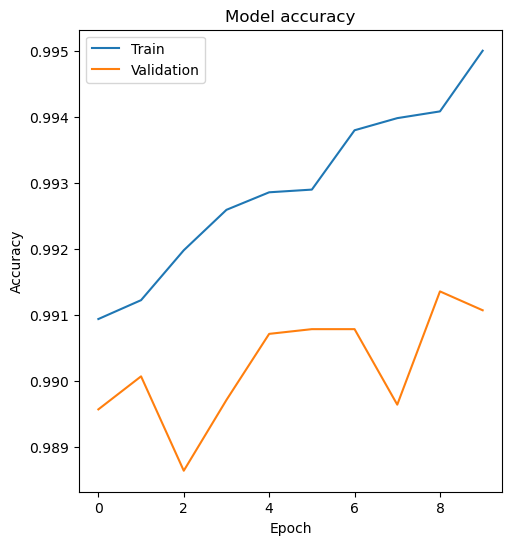

In [17]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

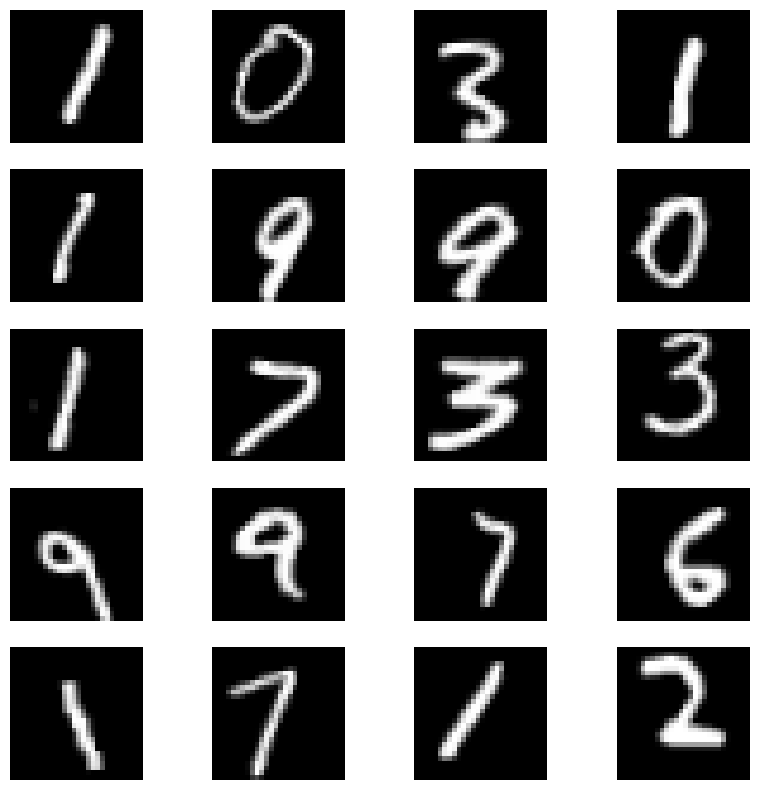

In [20]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Fit the data augmentation
datagen.fit(x_train_cnn)

# # Use the data generator to augment the training data
# cnn_model.fit(datagen.flow(x_train_cnn, y_train, batch_size=64), epochs=10, validation_data=(x_val_cnn, y_val))

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_cnn, y_train, batch_size=64))

# Display the first image in the batch
plt.figure(figsize=(10,  10))
for i in range(20):  # Displaying  20 images in a  5x4 grid
    plt.subplot(5,  4, i +  1)
    plt.imshow(augmented_images[i].reshape(28,  28), cmap='gray')
    plt.axis('off')
plt.show()

In [21]:
# Define the CNN model
cnn_model_1 = Sequential([
    Conv2D(32, kernel_size=(3,  3), activation='relu', input_shape=(28,  28,  1)),
    MaxPooling2D(pool_size=(2,  2)),
    Conv2D(64, (3,  3), activation='relu'),
    MaxPooling2D(pool_size=(2,  2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use the data generator to augment the training data
cnn_history_1 = cnn_model_1.fit(datagen.flow(x_train_cnn, y_train, batch_size=64),
                            epochs=25,
                            validation_data=(x_val_cnn, y_val))

Epoch 1/25


2024-02-17 15:37:01.380127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


766/766 [==============================] - 8s 10ms/step - loss: 0.5041 - accuracy: 0.8396 - val_loss: 0.0703 - val_accuracy: 0.9776
Epoch 2/25
766/766 [==============================] - 7s 10ms/step - loss: 0.2067 - accuracy: 0.9387 - val_loss: 0.0542 - val_accuracy: 0.9823
Epoch 3/25
766/766 [==============================] - 8s 10ms/step - loss: 0.1524 - accuracy: 0.9541 - val_loss: 0.0431 - val_accuracy: 0.9856
Epoch 4/25
766/766 [==============================] - 7s 10ms/step - loss: 0.1311 - accuracy: 0.9623 - val_loss: 0.0379 - val_accuracy: 0.9889
Epoch 5/25
766/766 [==============================] - 7s 10ms/step - loss: 0.1122 - accuracy: 0.9668 - val_loss: 0.0343 - val_accuracy: 0.9881
Epoch 6/25
766/766 [==============================] - 8s 10ms/step - loss: 0.0974 - accuracy: 0.9704 - val_loss: 0.0343 - val_accuracy: 0.9891
Epoch 7/25
766/766 [==============================] - 7s 10ms/step - loss: 0.0916 - accuracy: 0.9732 - val_loss: 0.0287 - val_accuracy: 0.9908
Epoch 8/25

### Technical Explanation

Originally used batch size = 256, number of steps was 192. 
Step size per epoch = total number of training samples / batch size.

Hence, with 64 per batch on second, I get a directly proportional step size increase. 

The benefit of smaller batches is that the model can generalise better to unseen data. Each update is less representative of the entire dataset, so the model can escape local minima and explore more solutions during optimisation. 

This could lead to faster convergence, lower memory requirements and prevent overfitting. 

<ins>Conv2D = params > 0</ins>

Core building blocks of CNNs, applying a number of filters to the input to create feature maps. These allow the network to pick up on edges, shapes, etc. The parameters are the weights of these filters, and learning these parameters enables the model to extract useful features from the input images. 

<ins>MaxPooling2D = 0 params</ins>

These layers reduce the spatial dimensions (height and width) of the input feature maps by outputting the maximum value in each patch of the feature map covered by the pooling kernel. Max pooling has no learnable parameters, they just help reduce computation and control overfitting by abstracting the input features.

<ins>Flatten and Dense = 0 and >>> params</ins>

Flatten converts the 2D feature maps into a 1D vector. Doesn't have learnable parameters; simply restructures the input data so it can be fed into a dense layer. 

Dense (fully connected) layers perform classification on the features extracted and downsampled by the previous layers. Each neuron is connected to all previous neurons. The parameters here are the weights and biases of these connections. 

The number of parameters in a Dense layer is: (input_features * output_neurons) + output_neurons

This is where most of the model's parameters reside, and contributes massively to the predictive power. 

<ins>Dropout = 0</ins>

Regularisation technique where proportion of the layer's inputs are randomly set to zero during training. 

Dropout layers do not have learnable parameters; they help reduce overfitting by disrupting co-adaptations among neurons during training.

<ins>Adam Optimiser</ins>

Helps in minimising the loss by adjusting the weights of the network based on the first and second moments of the gradients. It adapts the learning rate for each weight of the model, which can lead to more efficient training and convergence to lower loss values.

In [22]:
cnn_model_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (None, 128)              

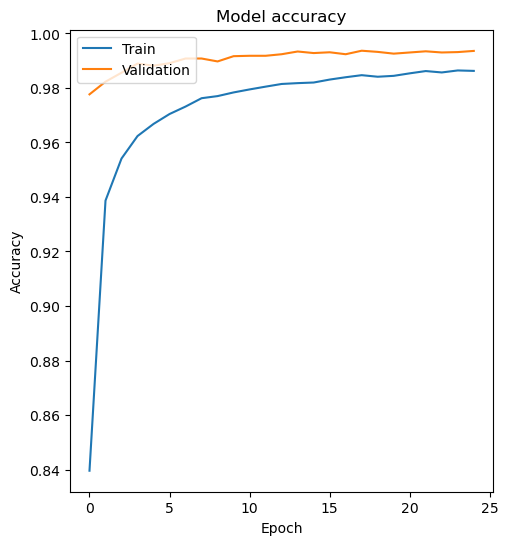

In [23]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history_1.history['accuracy'])
plt.plot(cnn_history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [24]:
# Evaluate on MNIST Validation Set
y_val_pred_probs = cnn_model_1.predict(x_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert the one-hot encoded validation labels back to class labels
y_val_true = np.argmax(y_val, axis=1)

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')
conf_mat = confusion_matrix(y_val_true, y_val_pred)
report = classification_report(y_val_true, y_val_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

438/438 [==============================] - 1s 2ms/step
Precision:  0.9935807070046965
Recall:  0.9935714285714285
F1 Score:  0.9935674949326598
Confusion Matrix:
 [[1366    0    0    1    0    0    1    0    1    0]
 [   0 1507    1    0    0    0    3    1    0    0]
 [   0    2 1399    0    0    0    0    2    1    0]
 [   0    0    1 1457    0    1    0    2    0    0]
 [   0    1    0    0 1379    0    0    1    0    6]
 [   1    0    0    8    0 1279    4    0    5    1]
 [   0    1    1    0    1    0 1332    0    0    0]
 [   0    3    2    0    3    0    0 1487    0    0]
 [   1    1    2    1    0    0    3    0 1374    4]
 [   0    1    0    2   12    1    0    2    5 1330]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1369
           1       0.99      1.00      1.00      1512
           2       1.00      1.00      1.00      1404
           3       0.99      1.00      0.99      1461
           

### Evaluation II

Now that we've got a stronger than 99% score on the MNIST just off MNIST alone, the plan is to evaluate on EMNIST and really push the the model generalisation.

I will also use gaussian noise to augment the dataset. 

First, import the EMNIST dataset and evaluate it.

In [25]:
from emnist import extract_training_samples, extract_test_samples
from sklearn.metrics import precision_score, recall_score, f1_score

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding
emnist_labels = to_categorical(emnist_labels, 10)
emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_labels.shape

((240000, 28, 28, 1), (240000, 10))

In [27]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import precision_score, recall_score, f1_score

# Correct variables for EMNIST
sample_indices = np.random.choice(len(emnist_images), size=50000, replace=False)
sample_images = emnist_images[sample_indices]
sample_labels = emnist_labels[sample_indices]

# Normalize the images to [0, 1]
sample_images = sample_images.astype('float32') / 255

# Reshape the images to add a dimension for the channel
sample_images = sample_images.reshape(-1, 28, 28, 1)

# Split the sample into five groups
split_size = 10000
split_images = np.array_split(sample_images, 5)
split_labels = np.array_split(sample_labels, 5)

# List to store F1 scores for each group
f1_scores = []
recall_scores = []
precision_scores = []

for img_group, label_group in zip(split_images, split_labels):
    # Predict the labels
    pred_probs = cnn_model_1.predict(img_group)
    pred_labels = np.argmax(pred_probs, axis=1)

    # Calculate metrics
    precision = precision_score(np.argmax(label_group, axis=1), pred_labels, average='weighted', zero_division=0)
    recall = recall_score(np.argmax(label_group, axis=1), pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(np.argmax(label_group, axis=1), pred_labels, average='weighted', zero_division=0)

    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Calculate average scores across all groups
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

print("Average Precision: ", average_precision)
print("Average Recall: ", average_recall)
print("Average F1 Score: ", average_f1)

313/313 [==============================] - 1s 2ms/step
Average Precision:  0.009742086
Average Recall:  0.09866
Average F1 Score:  0.017731877317352623


In [28]:
average_precision = np.mean(precision_scores)
average_recall = np.mean(recall_scores)
average_f1 = np.mean(f1_scores)

print("Average Precision: ", average_precision)
print("Average Recall: ", average_recall)
print("Average F1 Score: ", average_f1)

Average Precision:  0.009742086
Average Recall:  0.09866
Average F1 Score:  0.017731877317352623


Second, increase the number of conv layers, reduce batch size, and add patience. 

In [29]:
cnn_model_2 = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),  # New convolutional layer
    MaxPooling2D(pool_size=(2, 2)),          # Corresponding pooling layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

cnn_model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
cnn_model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 3, 3, 128)         73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 1, 1, 128)       

In [19]:
cnn_history = cnn_model.fit(
    datagen.flow(x_train_cnn, y_train, batch_size=32),  # Reduced batch size
    epochs=30,  # More epochs
    validation_data=(x_val_cnn, y_val),
    callbacks=[early_stopping]  # Callbacks for early stopping
)

Epoch 1/30


2024-02-17 14:54:32.659997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1532/1532 [==============================] - 10s 7ms/step - loss: 0.4904 - accuracy: 0.8435 - val_loss: 0.1152 - val_accuracy: 0.9648
Epoch 2/30
1532/1532 [==============================] - 11s 7ms/step - loss: 0.1940 - accuracy: 0.9420 - val_loss: 0.0810 - val_accuracy: 0.9748
Epoch 3/30
1532/1532 [==============================] - 11s 7ms/step - loss: 0.1477 - accuracy: 0.9563 - val_loss: 0.0888 - val_accuracy: 0.9724
Epoch 4/30
1532/1532 [==============================] - 12s 8ms/step - loss: 0.1262 - accuracy: 0.9631 - val_loss: 0.0695 - val_accuracy: 0.9787
Epoch 5/30
1532/1532 [==============================] - 10s 7ms/step - loss: 0.1159 - accuracy: 0.9660 - val_loss: 0.0786 - val_accuracy: 0.9751
Epoch 6/30
1532/1532 [==============================] - 11s 7ms/step - loss: 0.1051 - accuracy: 0.9689 - val_loss: 0.0649 - val_accuracy: 0.9820
Epoch 7/30
1532/1532 [==============================] - 11s 7ms/step - loss: 0.0987 - accuracy: 0.9707 - val_loss: 0.0582 - val_accuracy: 0.9

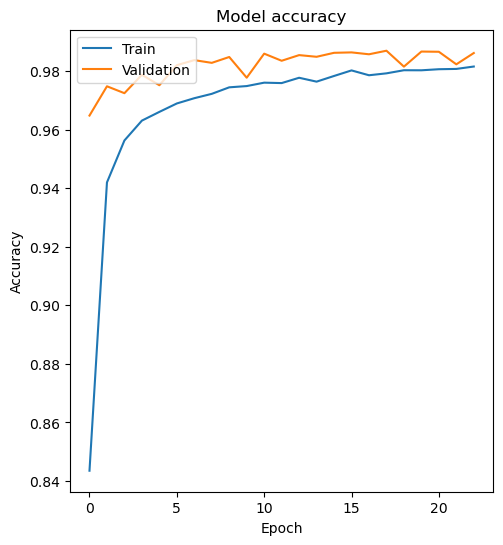

In [20]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [21]:
# Evaluate on MNIST Validation Set
y_val_pred_probs = cnn_model.predict(x_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)

# Convert the one-hot encoded validation labels back to class labels
y_val_true = np.argmax(y_val, axis=1)

# Calculate the precision, recall, f1 score, confusion matrix, and classification report
precision = precision_score(y_val_true, y_val_pred, average='weighted')
recall = recall_score(y_val_true, y_val_pred, average='weighted')
f1 = f1_score(y_val_true, y_val_pred, average='weighted')
conf_mat = confusion_matrix(y_val_true, y_val_pred)
report = classification_report(y_val_true, y_val_pred)

print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", report)

438/438 [==============================] - 1s 2ms/step
Precision:  0.9869569218815597
Recall:  0.9869285714285714
F1 Score:  0.9869246827604005
Confusion Matrix:
 [[1353    0    1    0    3    2    3    0    1    6]
 [   2 1505    1    0    0    0    2    2    0    0]
 [   1    3 1375   11    2    0    0    9    3    0]
 [   0    0    4 1454    0    2    0    1    0    0]
 [   0    1    0    0 1379    0    1    2    1    3]
 [   0    0    0   11    1 1278    1    1    4    2]
 [   4    3    2    0    2    6 1314    0    4    0]
 [   0    1   24    2    3    1    0 1462    0    2]
 [   1    0    3    1    0    1    1    1 1375    3]
 [   3    0    0    2   12    7    0    0    7 1322]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      1369
           1       0.99      1.00      1.00      1512
           2       0.98      0.98      0.98      1404
           3       0.98      1.00      0.99      1461
           

Very strange issues here. Will do some more data investigation.

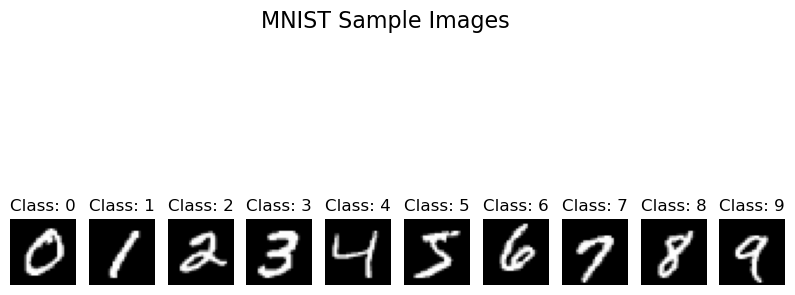

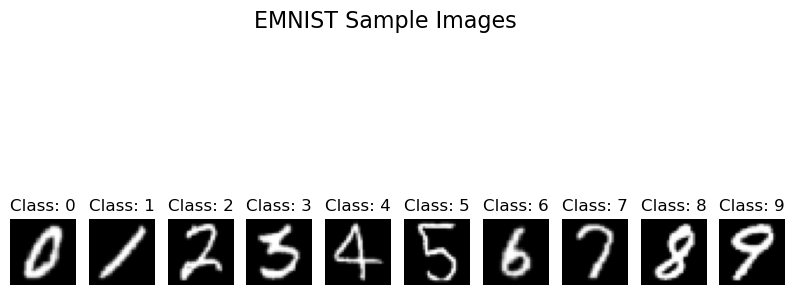

In [34]:
import matplotlib.pyplot as plt

def plot_sample_images(images, labels, title, num_classes=10):
    fig, axes = plt.subplots(1, num_classes, figsize=(10, 5))
    fig.suptitle(title, fontsize=16)
    for i in range(num_classes):
        idx = np.where(labels == i)[0][0]
        ax = axes[i]
        ax.imshow(images[idx], cmap='gray')
        ax.axis('off')
        ax.set_title(f"Class: {i}")

# Plot MNIST sample images
plot_sample_images(x_train_full, np.argmax(y_train_full, axis=1), "MNIST Sample Images")

# Plot EMNIST sample images (assuming 'emnist_images' and 'emnist_labels' are already loaded and preprocessed)
plot_sample_images(emnist_images, np.argmax(emnist_labels, axis=1), "EMNIST Sample Images")

plt.show()

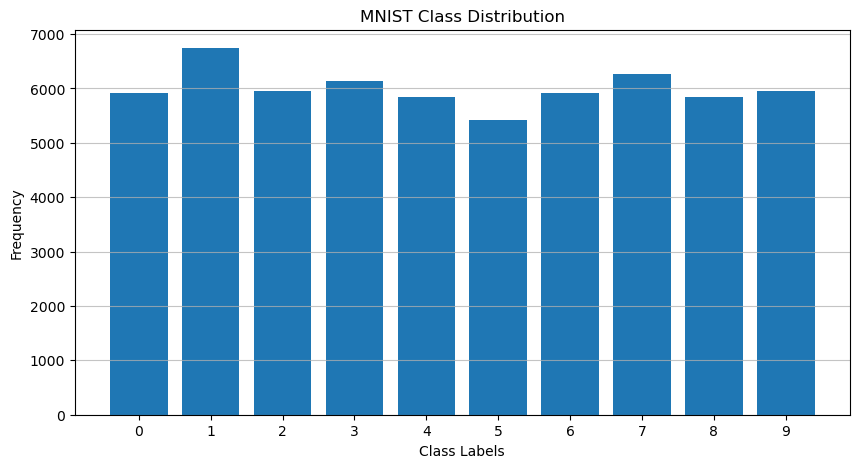

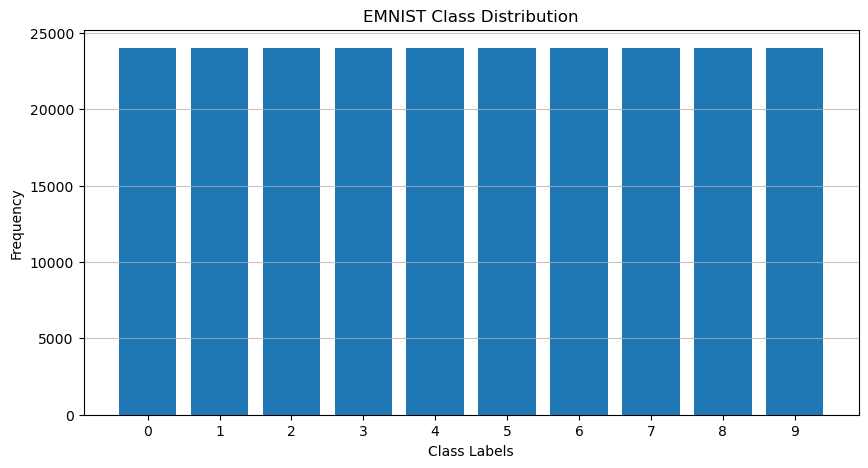

In [35]:
def plot_class_distribution(labels, title):
    plt.figure(figsize=(10, 5))
    plt.hist(labels, bins=np.arange(-0.5, 10, 1), rwidth=0.8)
    plt.title(title)
    plt.xticks(np.arange(0, 10, 1))
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)
    plt.show()

# Plot MNIST class distribution
plot_class_distribution(np.argmax(y_train_full, axis=1), "MNIST Class Distribution")

# Plot EMNIST class distribution
plot_class_distribution(np.argmax(emnist_labels, axis=1), "EMNIST Class Distribution")


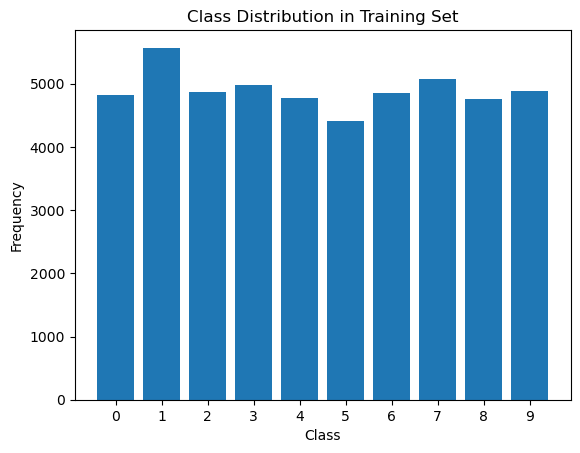

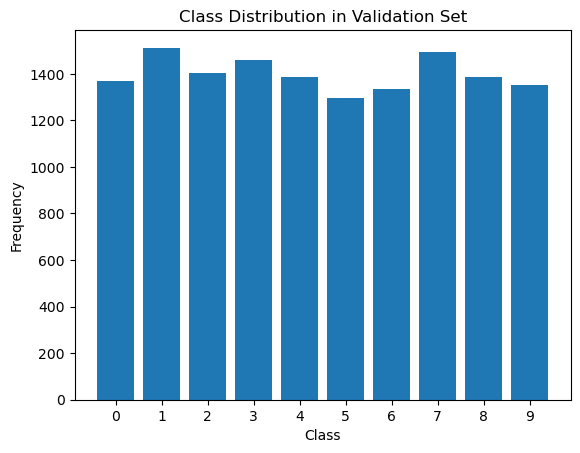

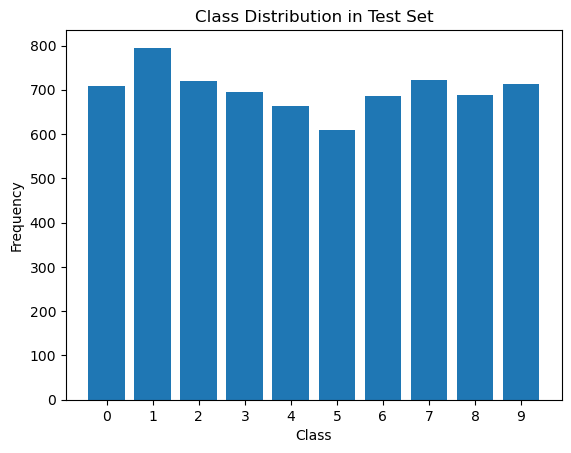

In [36]:
# Load MNIST data again
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Combine the datasets
combined_images = np.concatenate((x_train_full, x_test))
combined_labels = np.concatenate((y_train_full, y_test))

# Split the full training data into training (70%) and temporary set (30%)
split_1 = int(0.7 * len(combined_images))
x_train, x_temp = combined_images[:split_1], combined_images[split_1:]
y_train, y_temp = combined_labels[:split_1], combined_labels[split_1:]

# Split the temporary set into validation (20% of full data) and test set (10% of full data)
split_2 = int(0.6667 * len(x_temp))  # 2/3 of temp is 20% of full
x_val, x_test = x_temp[:split_2], x_temp[split_2:]
y_val, y_test = y_temp[:split_2], y_temp[split_2:]

# Function to plot class distribution
def plot_class_distribution(labels, dataset_name):
    # Count the number of each class
    class_counts = np.sum(labels, axis=0)
    # Plot
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Plot the class distribution for each set
plot_class_distribution(y_train, 'Training')
plot_class_distribution(y_val, 'Validation')
plot_class_distribution(y_test, 'Test')

We need to split the dataset evenly by class to avoid bias. 

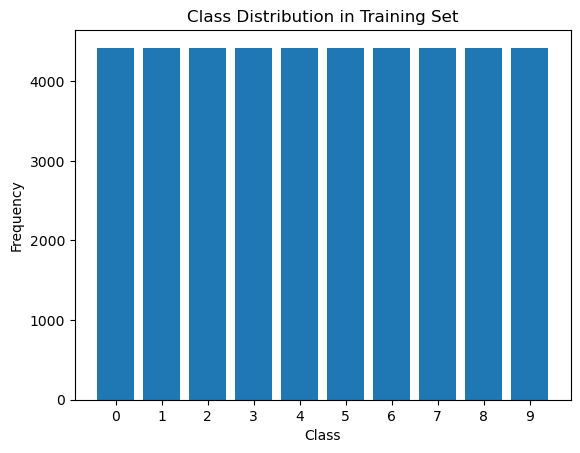

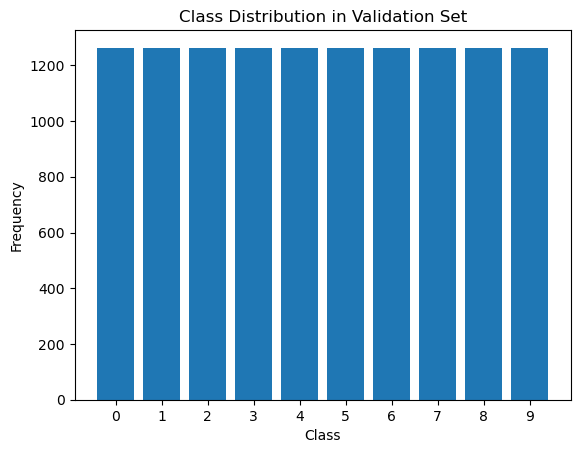

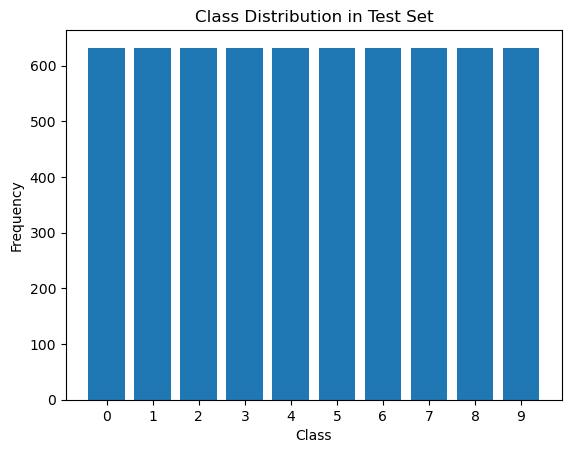

In [43]:
# Load the MNIST dataset
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()

# Convert labels to one-hot encoding
y_train_full = to_categorical(y_train_full, 10)
y_test = to_categorical(y_test, 10)

# Flatten y_train_full and y_test to work with non-categorical labels temporarily
y_train_full_flat = np.argmax(y_train_full, axis=1)
y_test_flat = np.argmax(y_test, axis=1)

# Combine datasets to balance them together
x_combined = np.concatenate((x_train_full, x_test))
y_combined_flat = np.concatenate((y_train_full_flat, y_test_flat))

# Determine the minimum class size
min_class_size = min(np.bincount(y_combined_flat))

# Create a balanced dataset
x_balanced = np.empty((0, 28, 28))
y_balanced_flat = np.empty(0, dtype=int)

for i in range(10):
    indices = np.where(y_combined_flat == i)[0]
    balanced_indices = np.random.choice(indices, min_class_size, replace=False)
    x_balanced = np.vstack((x_balanced, x_combined[balanced_indices]))
    y_balanced_flat = np.concatenate((y_balanced_flat, y_combined_flat[balanced_indices]))

# Convert labels back to categorical
y_balanced = to_categorical(y_balanced_flat, 10)

# Split the balanced dataset into training (70%), validation (20%), and test (10%)
x_temp, x_test, y_temp, y_test = train_test_split(x_balanced, y_balanced, test_size=0.1, stratify=y_balanced_flat)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=(2/9), stratify=y_temp)

# Normalise the images to [0, 1]
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Reshape the images to add a dimension for the channel
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

# Function to plot class distribution
def plot_class_distribution(labels, dataset_name):
    # Count the number of each class
    class_counts = np.sum(labels, axis=0)
    # Plot
    plt.bar(range(10), class_counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {dataset_name} Set')
    plt.xticks(range(10))
    plt.show()

# Plot the class distribution for each set
plot_class_distribution(y_train, 'Training')
plot_class_distribution(y_val, 'Validation')
plot_class_distribution(y_test, 'Test')

Now we train again, test, and map to EMNIST data.

In [45]:
# Reshape the images to add a dimension for the channel
x_train_cnn = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val_cnn = x_val.reshape(x_val.shape[0], 28, 28, 1)

In [48]:
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)

# Fit the data augmentation
datagen.fit(x_train_cnn)

# Generate a batch of augmented images and labels
augmented_images, augmented_labels = next(datagen.flow(x_train_cnn, y_train, batch_size=64))

In [49]:
# Define the CNN model
cnn_model_1 = Sequential([
    Conv2D(32, kernel_size=(3,  3), activation='relu', input_shape=(28,  28,  1)),
    MaxPooling2D(pool_size=(2,  2)),
    Conv2D(64, (3,  3), activation='relu'),
    MaxPooling2D(pool_size=(2,  2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])

# Compile the model
cnn_model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use the data generator to augment the training data
cnn_history_1 = cnn_model_1.fit(datagen.flow(x_train_cnn, y_train, batch_size=64),
                            epochs=25,
                            validation_data=(x_val_cnn, y_val))

Epoch 1/25


2024-02-17 15:59:45.517874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


691/691 [==============================] - 6s 9ms/step - loss: 0.5216 - accuracy: 0.8335 - val_loss: 0.0864 - val_accuracy: 0.9735
Epoch 2/25
691/691 [==============================] - 6s 9ms/step - loss: 0.2249 - accuracy: 0.9332 - val_loss: 0.0539 - val_accuracy: 0.9828
Epoch 3/25
691/691 [==============================] - 6s 9ms/step - loss: 0.1663 - accuracy: 0.9495 - val_loss: 0.0414 - val_accuracy: 0.9868
Epoch 4/25
691/691 [==============================] - 6s 9ms/step - loss: 0.1370 - accuracy: 0.9598 - val_loss: 0.0427 - val_accuracy: 0.9862
Epoch 5/25
691/691 [==============================] - 6s 9ms/step - loss: 0.1164 - accuracy: 0.9651 - val_loss: 0.0418 - val_accuracy: 0.9857
Epoch 6/25
691/691 [==============================] - 6s 9ms/step - loss: 0.1078 - accuracy: 0.9685 - val_loss: 0.0385 - val_accuracy: 0.9872
Epoch 7/25
691/691 [==============================] - 6s 9ms/step - loss: 0.0983 - accuracy: 0.9706 - val_loss: 0.0331 - val_accuracy: 0.9897
Epoch 8/25
691/69

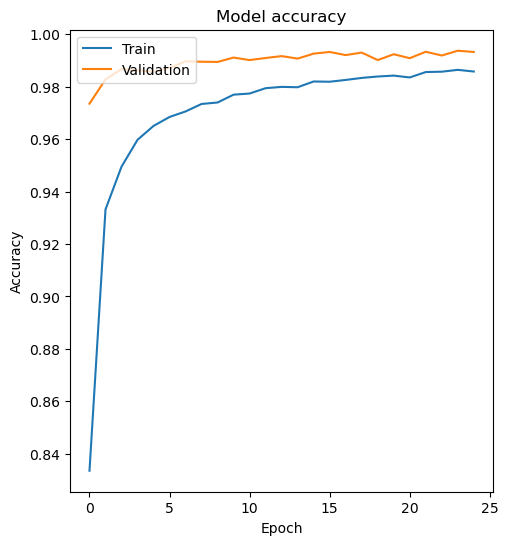

In [50]:
# Plot training and validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_history_1.history['accuracy'])
plt.plot(cnn_history_1.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

395/395 [==============================] - 1s 2ms/step


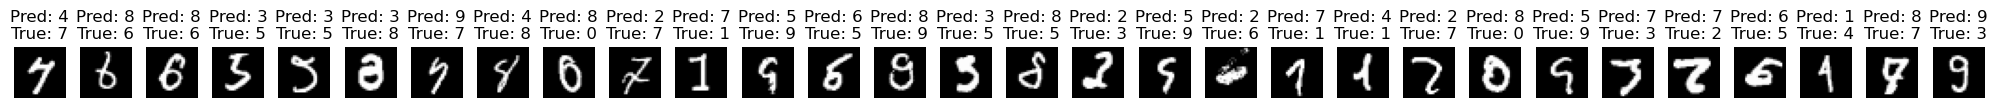

In [52]:
import numpy as np
import matplotlib.pyplot as plt

# Predict classes on the validation set
predictions = cnn_model_1.predict(x_val_cnn)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_val, axis=1)

# Identify misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_images = x_val_cnn[misclassified_indices]
misclassified_predictions = predicted_classes[misclassified_indices]
true_labels_misclassified = true_classes[misclassified_indices]

# Plot a sample of misclassified images
num_images_to_show = 30
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 4))
for i, ax in enumerate(axes):
    if i < len(misclassified_indices):
        ax.imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Pred: {misclassified_predictions[i]}\nTrue: {true_labels_misclassified[i]}')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [54]:
from emnist import extract_training_samples, extract_test_samples
from sklearn.metrics import precision_score, recall_score, f1_score

# Load EMNIST data
emnist_images, emnist_labels = extract_training_samples('digits')
emnist_test_images, emnist_test_labels = extract_test_samples('digits')

# Normalize the images to [0, 1]
emnist_images = emnist_images.astype('float32') / 255
emnist_test_images = emnist_test_images.astype('float32') / 255

# Convert labels to one-hot encoding
emnist_labels = to_categorical(emnist_labels, 10)
emnist_test_labels = to_categorical(emnist_test_labels, 10)

# Reshape the images to add a dimension for the channel
emnist_images = emnist_images.reshape(emnist_images.shape[0], 28, 28, 1)
emnist_test_images = emnist_test_images.reshape(emnist_test_images.shape[0], 28, 28, 1)

emnist_images.shape, emnist_labels.shape

((240000, 28, 28, 1), (240000, 10))

In [59]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 5.2 MB/s eta 0:00:00a 0:00:01


63/63 [==============================] - 0s 2ms/step


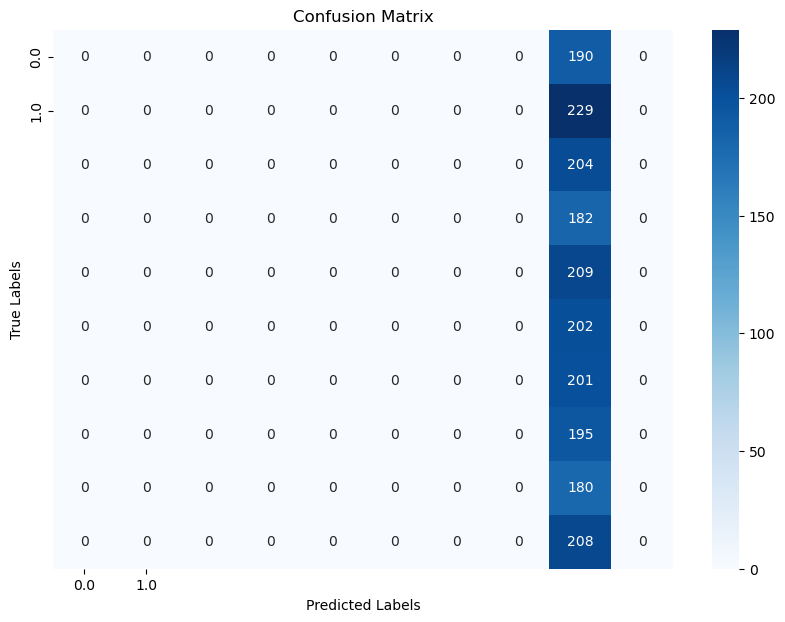

Precision:  0.0081
Recall:  0.09
F1 Score:  0.014862385321100915


In [60]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming emnist_labels are not one-hot encoded
unique_classes = np.unique(emnist_labels)
sample_per_class = 1000
indices = []

for cls in unique_classes:
    cls_indices = np.where(emnist_labels == cls)[0]
    cls_sample_indices = np.random.choice(cls_indices, sample_per_class, replace=False)
    indices.append(cls_sample_indices)

# Flatten the list of indices and sample images and labels
balanced_indices = np.concatenate(indices)
balanced_images = emnist_images[balanced_indices]
balanced_labels = emnist_labels[balanced_indices]

# Normalize and reshape
balanced_images = balanced_images.astype('float32') / 255
balanced_images = balanced_images.reshape(-1, 28, 28, 1)

# Predict the labels
pred_probs = cnn_model_1.predict(balanced_images)
pred_labels = np.argmax(pred_probs, axis=1)
true_labels = np.argmax(balanced_labels, axis=1)  # Assuming balanced_labels is one-hot encoded; if not, skip np.argmax

# Calculate metrics
precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
f1 = f1_score(true_labels, pred_labels, average='weighted', zero_division=0)

# Generate confusion matrix
conf_mat = confusion_matrix(true_labels, pred_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=unique_classes, yticklabels=unique_classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print metrics
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)

7500/7500 [==============================] - 12s 2ms/step


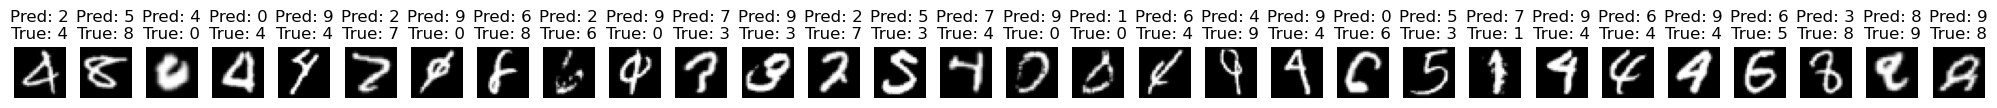

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Predict classes on the validation set
predictions = cnn_model_1.predict(emnist_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(emnist_labels, axis=1)

# Identify misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]
misclassified_images = emnist_images[misclassified_indices]
misclassified_predictions = predicted_classes[misclassified_indices]
true_labels_misclassified = true_classes[misclassified_indices]

# Plot a sample of misclassified images
num_images_to_show = 30
fig, axes = plt.subplots(1, num_images_to_show, figsize=(20, 4))
for i, ax in enumerate(axes):
    if i < len(misclassified_indices):
        ax.imshow(misclassified_images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'Pred: {misclassified_predictions[i]}\nTrue: {true_labels_misclassified[i]}')
        ax.axis('off')
plt.tight_layout()
plt.show()

In [57]:
print("Number of misclassified images: ", len(misclassified_indices))
print("Total number of images in the EMNIST dataset: ", len(emnist_images))

Number of misclassified images:  1603
Total number of images in the EMNIST dataset:  240000
